In [250]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import random
import sympy as sp
import IPython.display as disp
from typing import List, Tuple

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer

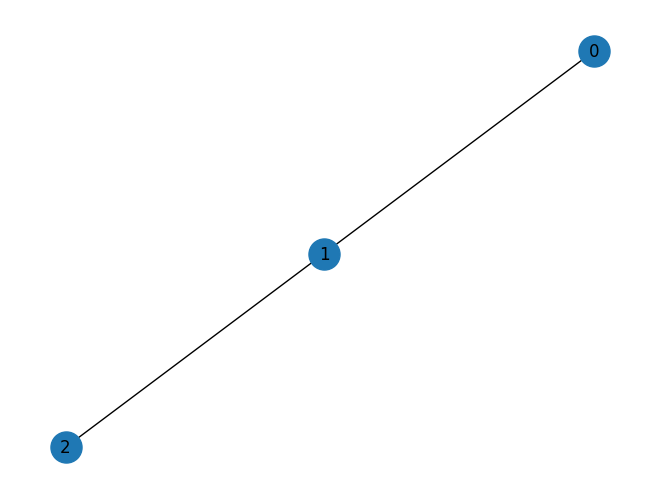

In [251]:
# n = 5
 
# graph = rx.PyGraph()
# graph.add_nodes_from(np.arange(0, n, 1))
# graph_edge_list = [
#     (0, 1, 1.0),
#     (0, 2, 1.0),
#     (0, 4, 1.0),
#     (1, 2, 1.0),
#     (2, 3, 1.0),
#     (3, 4, 1.0),
# ]

n = 3
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph_edge_list = [
    (0, 1, 1.0),
    (1, 2, 1.0),
]

graph_num_edges = len(graph_edge_list)

graph.add_edges_from(graph_edge_list)
draw_graph(graph, node_size=500, with_labels=True)

In [252]:
# f(xk, xp) = 1 => a aresta (vk, vp) pertence ao corte
def f(xk: bool, xp: bool) -> bool:
    return (xk and (not xp) ) or ((not xk) and xp)

# g(xk, xp) = 1 => a aresta (vk, vp) não pertence ao corte
def g(xk: bool, xp: bool) -> bool:
    return ((not xk) and (not xp) ) or (xk and xp)

# função auxiliar para geração de um corte aleatório
def random_cut(n: int) -> list:
    rcut = [random.randint(0,1) for _ in range(n)]
    return rcut

def print_matrix(z: list) -> None:
    disp.display(disp.Math(f"z="+sp.latex(sp.Matrix(z))))

def cut_z(edge: Tuple, x: list, n: int, m: int) -> List[List[int]]:
    z = [[0 for _ in range(m+1)] for _ in range(m+1)]

    k = edge[0]
    p = edge[1]

    edge_cut = f(x[k], x[p])
    no_cut_edge = g(x[k], x[p])

    z[1][1] = int(edge_cut)
    z[1][0] = int(no_cut_edge)

    for i in range(1, m):
        for j in range(i, -1, -1):
            z[i+1][j+1] = int(edge_cut and z[i][j])
            z[i+1][j] = int(no_cut_edge and z[i][j])

    return z

def partition_from_cut(x: List[int]) -> Tuple[List[str], List[str]]:
    V1 = []
    V2 = []
    n = len(x)
    for idx, xi in enumerate(x):
        if xi == 1:
            V1.append(f"{idx}")
        else:
            V2.append(f"{idx}")
    return V1, V2

def calc_cut_size(n: int, edges: list, x: List) -> dict:
    m = len(edges)

    cut_size = 0
    for edge in edges:
        z = cut_z(edge, x, n, m)
        cut_size += z[m][m]

        # z = sp.Matrix(z)
        # latex_strz = r"z_{"+sp.latex(sp.Tuple(*edge))+r"}=" + sp.latex(z)
        # disp.display(disp.Math(latex_strz))

    # p1, p2 = partition_from_cut(x)
    # xs = ''.join([f'x_{{{i}}}' for i in range(0, n)])
    # disp.display(disp.Math(f"x={xs}"))

    # V1 = sp.FiniteSet(*p1)
    # V2 = sp.FiniteSet(*p2)

    # latex_strv = r"V_1 = " + sp.latex(V1) + r", V_2 = " + sp.latex(V2)    
    # disp.display(disp.Math(latex_strv))

    x_rev = x[::-1]
    return {
        "cut_str": ''.join([f'{x_rev[i]}' for i in range(0, n)]),
        "cut_size": cut_size,
    }

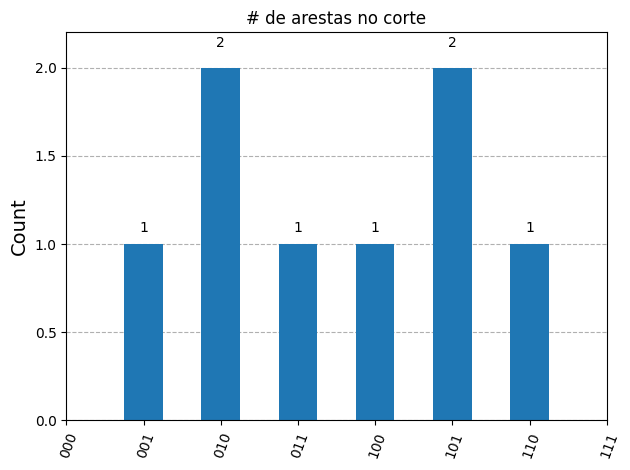

In [253]:
cut_list = [random_cut(n) for _ in range(100)]

cut_info_dict = {}
for x in cut_list:
    cut_info = calc_cut_size(n, graph_edge_list, x)
    cut_info_dict[cut_info['cut_str']] = cut_info['cut_size']

plot_histogram(cut_info_dict, title="# de arestas no corte")

3 12 6 5


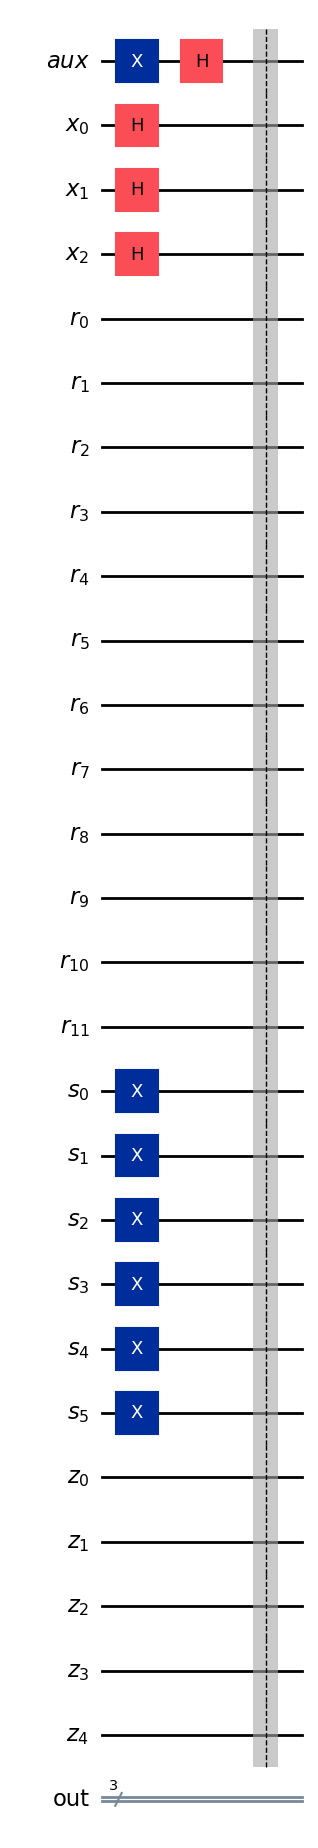

In [254]:
'''
Create the quantum circuit for the example
'''

range_z = int((((graph_num_edges + 1) * (graph_num_edges + 2)) / 2) - 1)
range_r = int(4 * (graph_num_edges * (graph_num_edges + 1)) / 2)
range_s = int(2 * (graph_num_edges * (graph_num_edges + 1)) / 2)

aux = QuantumRegister(1, 'aux')

x_reg = QuantumRegister(n, 'x')
r_reg = QuantumRegister(range_r, 'r')
s_reg = QuantumRegister(range_s, 's')

z_reg = QuantumRegister(range_z, 'z')
readout = ClassicalRegister(n, 'out')

qc = QuantumCircuit(aux, x_reg, r_reg, s_reg, z_reg, readout, name="max_cut")

qc.x(aux)
qc.h(aux)

'''
Initialize the system and set it in a uniform superpostion   -> lines 1 and 2 of Algorithm 1 in paper
'''

for qubit in s_reg:
    qc.x(qubit)

for qubit in x_reg:
    qc.h(qubit)
    
qc.barrier()

print(n, range_r, range_s, range_z)

circuit_drawer(qc, output="mpl", fold=-1)

In [255]:
'''
Create z_matrix to store elements of z_reg
'''

z_matrix = [ [ 0 for i in range(graph_num_edges + 1) ] for j in range(graph_num_edges + 1) ]
zij = 0
for i in range(1, graph_num_edges + 1):
    for j in range(i + 1):
        z_matrix[i][j] = zij
        zij += 1

print_matrix(z_matrix)

<IPython.core.display.Math object>

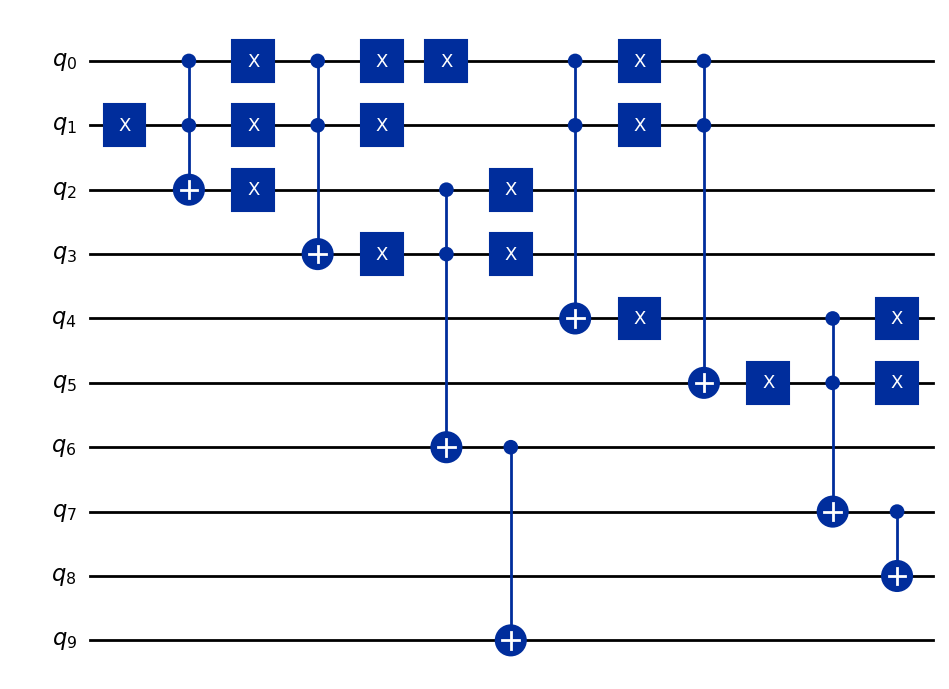

In [256]:
'''
Define the CFE subcircuit
'''

cfe = QuantumCircuit(10, name='CFE')

# EIIAC
cfe.x(1)
cfe.ccx(0, 1, 2)
cfe.x(0)
cfe.x(1)
cfe.ccx(0, 1, 3)
cfe.x(0)
cfe.x(2)
cfe.x(3)
cfe.ccx(2, 3, 6)
cfe.x(2)
cfe.x(3)

# EINIAC
cfe.x(0)
cfe.x(1)
cfe.ccx(0, 1, 4)
cfe.x(0)
cfe.x(1)
cfe.ccx(0, 1, 5)
cfe.x(4)
cfe.x(5)
cfe.ccx(4, 5, 7)
cfe.x(4)
cfe.x(5)

# CNOTS
cfe.cx(6, 9)
cfe.cx(7, 8)

cfe.draw("mpl")

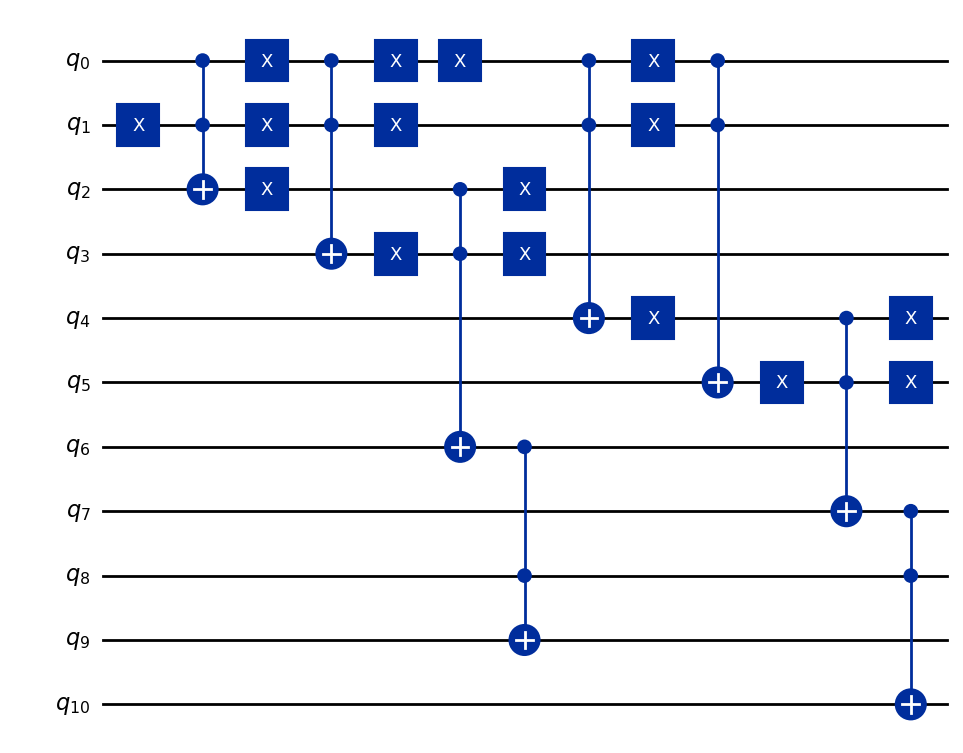

In [257]:
'''
Define the CSE subcircuit
'''

cse = QuantumCircuit(11, name='CSE')

# EIIAC
cse.x(1)
cse.ccx(0, 1, 2)
cse.x(0)
cse.x(1)
cse.ccx(0, 1, 3)
cse.x(0)
cse.x(2)
cse.x(3)
cse.ccx(2, 3, 6)
cse.x(2)
cse.x(3)

# EINIAC
cse.x(0)
cse.x(1)
cse.ccx(0, 1, 4)
cse.x(0)
cse.x(1)
cse.ccx(0, 1, 5)
cse.x(4)
cse.x(5)
cse.ccx(4, 5, 7)
cse.x(4)
cse.x(5)

# CNOTS
cse.ccx(6, 8, 9)
cse.ccx(7, 8, 10)

cse.draw("mpl")

In [258]:
'''
NOTE: There will always be an even number of solutions, since under maximum cut 101 is the same as 010.
For Fig. 1 in the paper, we set the number of solutions to 2.

YOU MAY NEED TO ADJUST THE NUMBER OF SOLUTIONS.
'''

num_solutions = 2   
num_runs = int(np.ceil(np.pi * np.sqrt((2**n) / num_solutions)) / 4)

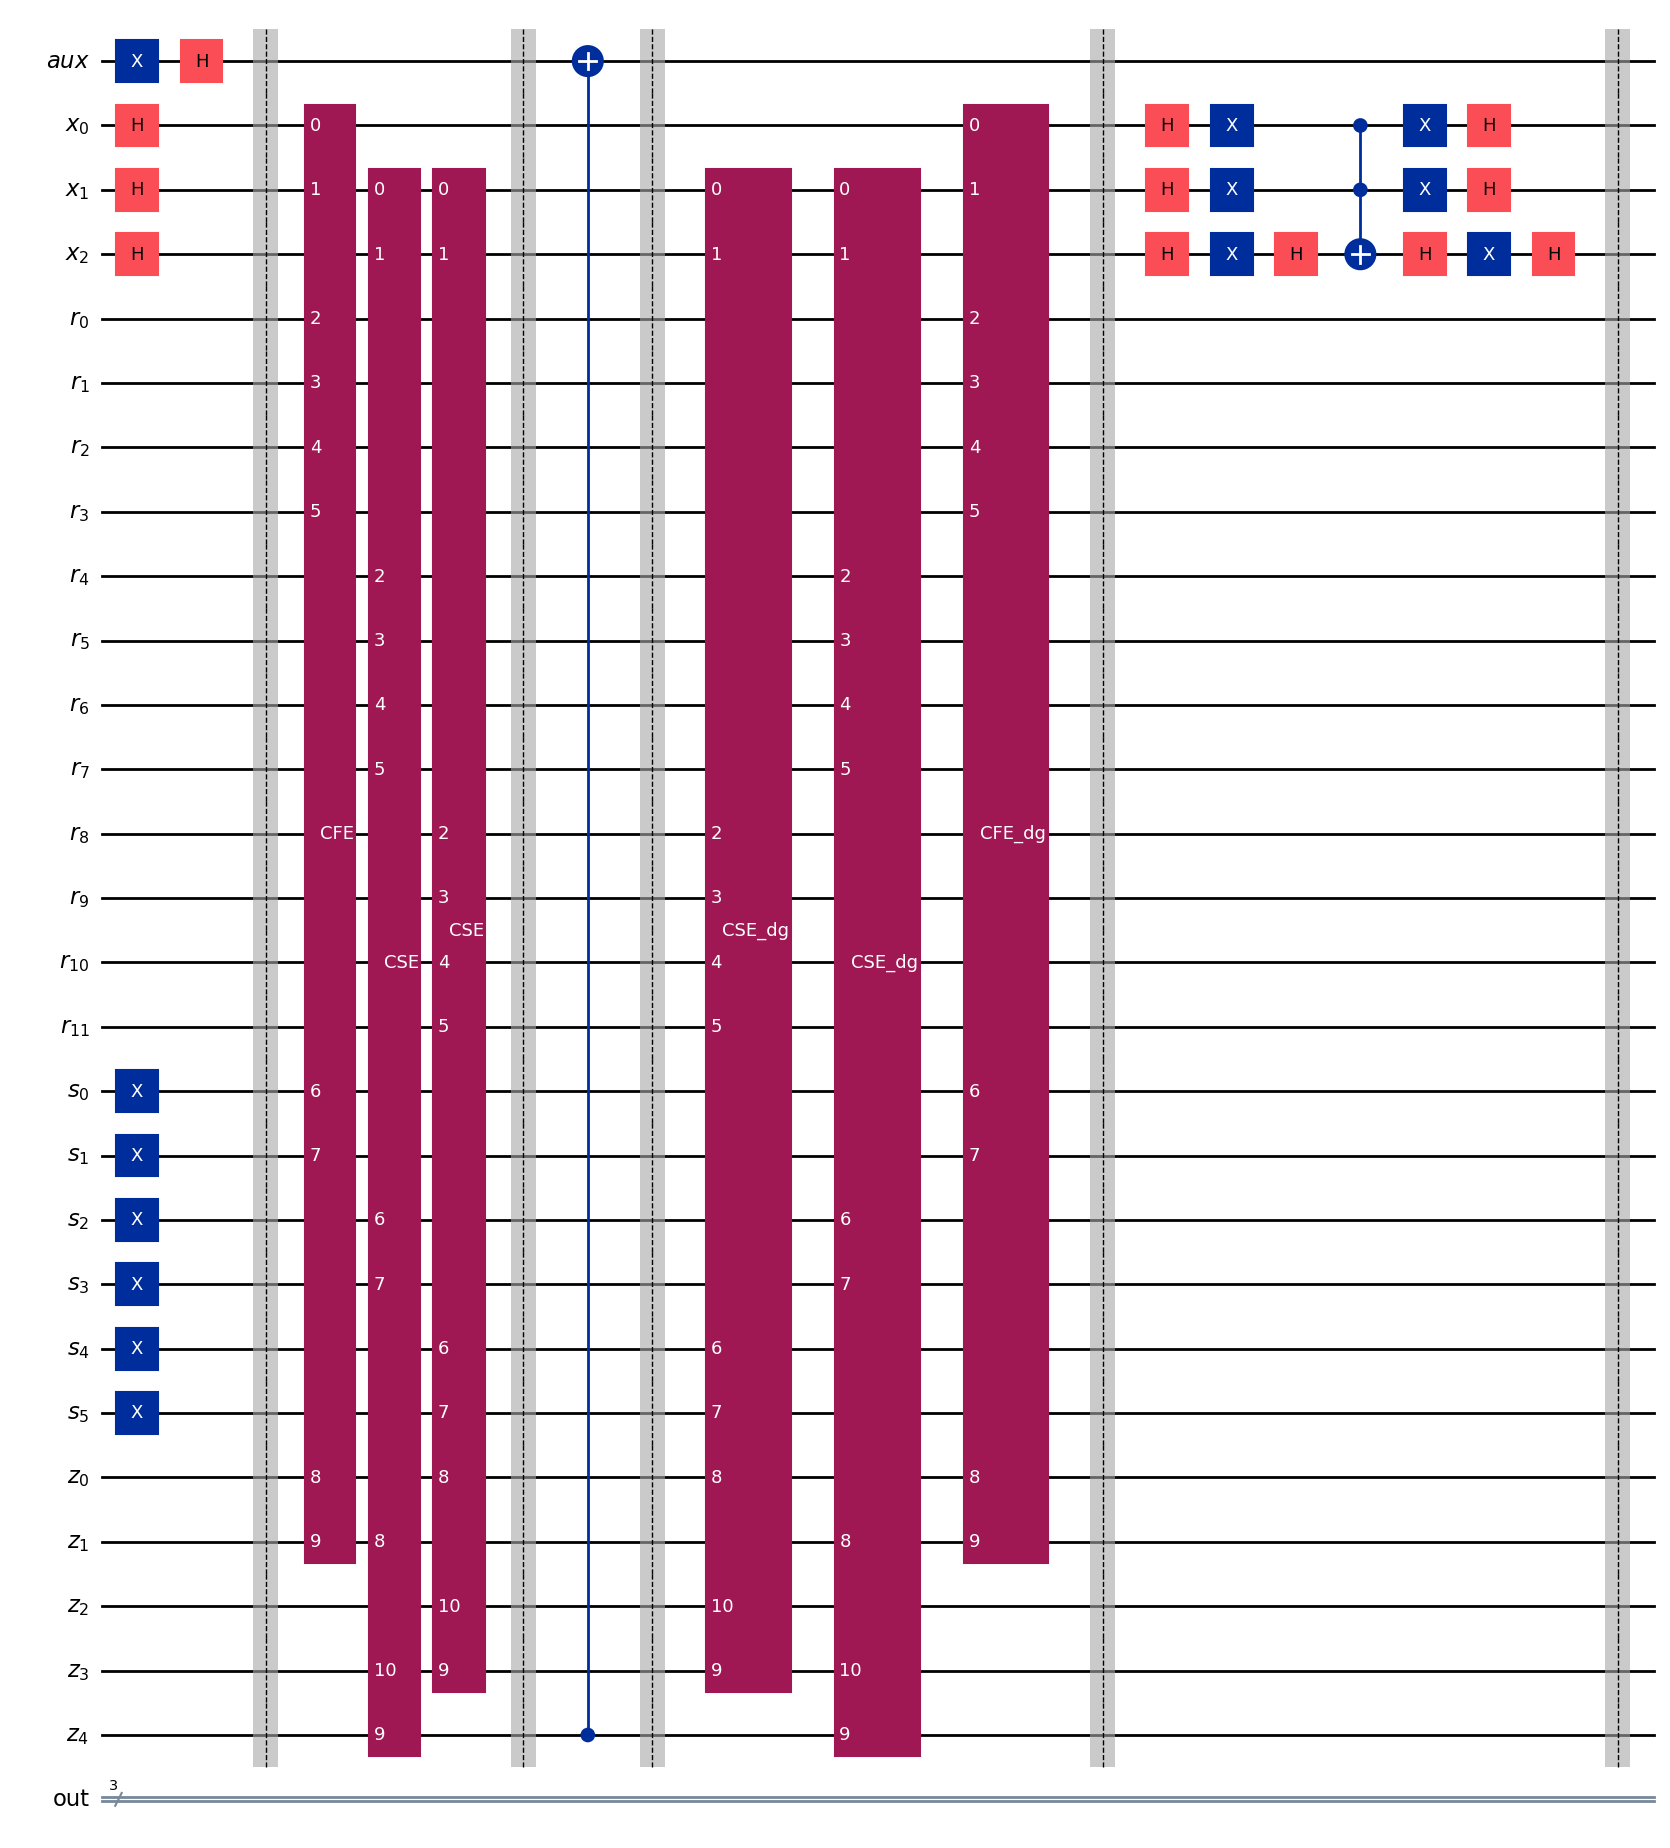

In [259]:
'''
Amplitude amplification
'''

for run in range(num_runs):
    # Apply CFE to |psi_1>   -> line 3 in Algorithm 1
    # It is assumed that the two vertices in the x_reg share an edge
    
    r = 4   
    s = 2
    
    edge_list = graph_edge_list.copy()

    if len(edge_list) > 0:
        
        index_v1 = edge_list[0][0]
        index_v2 = edge_list[0][1]
        edge_list.pop(0)
        
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[i] for i in range(4)]
        cfe_qubits += [s_reg[i] for i in range(2)]
        cfe_qubits += [z_reg[i] for i in range(2)]
        qc.append(cfe, cfe_qubits)

    # Apply CSE to |psi_2>   --> line 4 in Algorithm 1
    # It is assumed that the two vertices in the x_reg share an edge

    for i in range(1, graph_num_edges):
        
        index_v1 = edge_list[0][0]
        index_v2 = edge_list[0][1]
        
        cse_qubits = []
        for j in reversed(range(i+1)):
            cse_qubits += [x_reg[index_v1]]
            cse_qubits += [x_reg[index_v2]]
            cse_qubits += [r_reg[i] for i in range(r, r+4)]
            cse_qubits += [s_reg[i] for i in range(s, s+2)]
            cse_qubits += [z_reg[z_matrix[i][j]]]                     
            cse_qubits += [z_reg[z_matrix[i+1][j+1]]]                 
            cse_qubits += [z_reg[z_matrix[i+1][j]]]                     
            qc.append(cse, cse_qubits)
            cse_qubits.clear()
            r += 4
            s += 2
            
        edge_list.pop(0)

    '''
    Which qubit of register z_reg is used here depends on how many edges are there in the cut.
    For the example in Fig. 1 we expect 2 edges, and therefore we choose qubit 2 (counting from 0, 1, 2, etc.).
    This qubit should be in the state 1.
    
    YOU MAY NEED TO ADJUST THE CONTROL QUBIT IN THE CX GATE.
    '''
    
    qc.barrier()
    qc.cx(z_reg[len(z_reg)-1], aux)
    qc.barrier()

    '''
    Uncompute CSE and CFE operations
    '''
    edge_list = graph_edge_list.copy()
    for i in reversed(range(1, graph_num_edges)):
        index_v1 = edge_list[len(edge_list) - 1][0]
        index_v2 = edge_list[len(edge_list) - 1][1]

        cse_qubits = []
        for j in range(i+1):
            r -= 4
            s -= 2
            cse_qubits += [x_reg[index_v1]]
            cse_qubits += [x_reg[index_v2]]
            cse_qubits += [r_reg[i] for i in range(r, r+4)]
            cse_qubits += [s_reg[i] for i in range(s, s+2)]
            cse_qubits += [z_reg[z_matrix[i][j]]]                
            cse_qubits += [z_reg[z_matrix[i+1][j+1]]]                   
            cse_qubits += [z_reg[z_matrix[i+1][j]]]                      
            qc.append(cse.inverse(), cse_qubits)
            cse_qubits.clear()

        edge_list.pop(0)
    
    edge_list = [graph_edge_list[0]]
    
    if len(edge_list) > 0:
        index_v1 = edge_list[0][0]
        index_v2 = edge_list[0][1]
        
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[i] for i in range(4)]
        cfe_qubits += [s_reg[i] for i in range(2)]
        cfe_qubits += [z_reg[i] for i in range(2)] 
        qc.append(cfe.inverse(), cfe_qubits)   
    
        edge_list.pop()

    '''
    Diffusion operations
    '''
    qc.barrier()
    
    for qubit in x_reg:
        qc.h(qubit)
        qc.x(qubit)
        
    # apply CZ to x_reg
    qc.h(x_reg[len(x_reg) - 1])
    multiplexer = [x_reg[i] for i in range(len(x_reg) - 1)]
    qc.mcx(multiplexer, x_reg[len(x_reg) - 1])
    qc.h(x_reg[len(x_reg) - 1])
    
    for qubit in x_reg:
        qc.x(qubit)
        qc.h(qubit)

    qc.barrier()

circuit_drawer(qc, output="mpl", fold=-1)

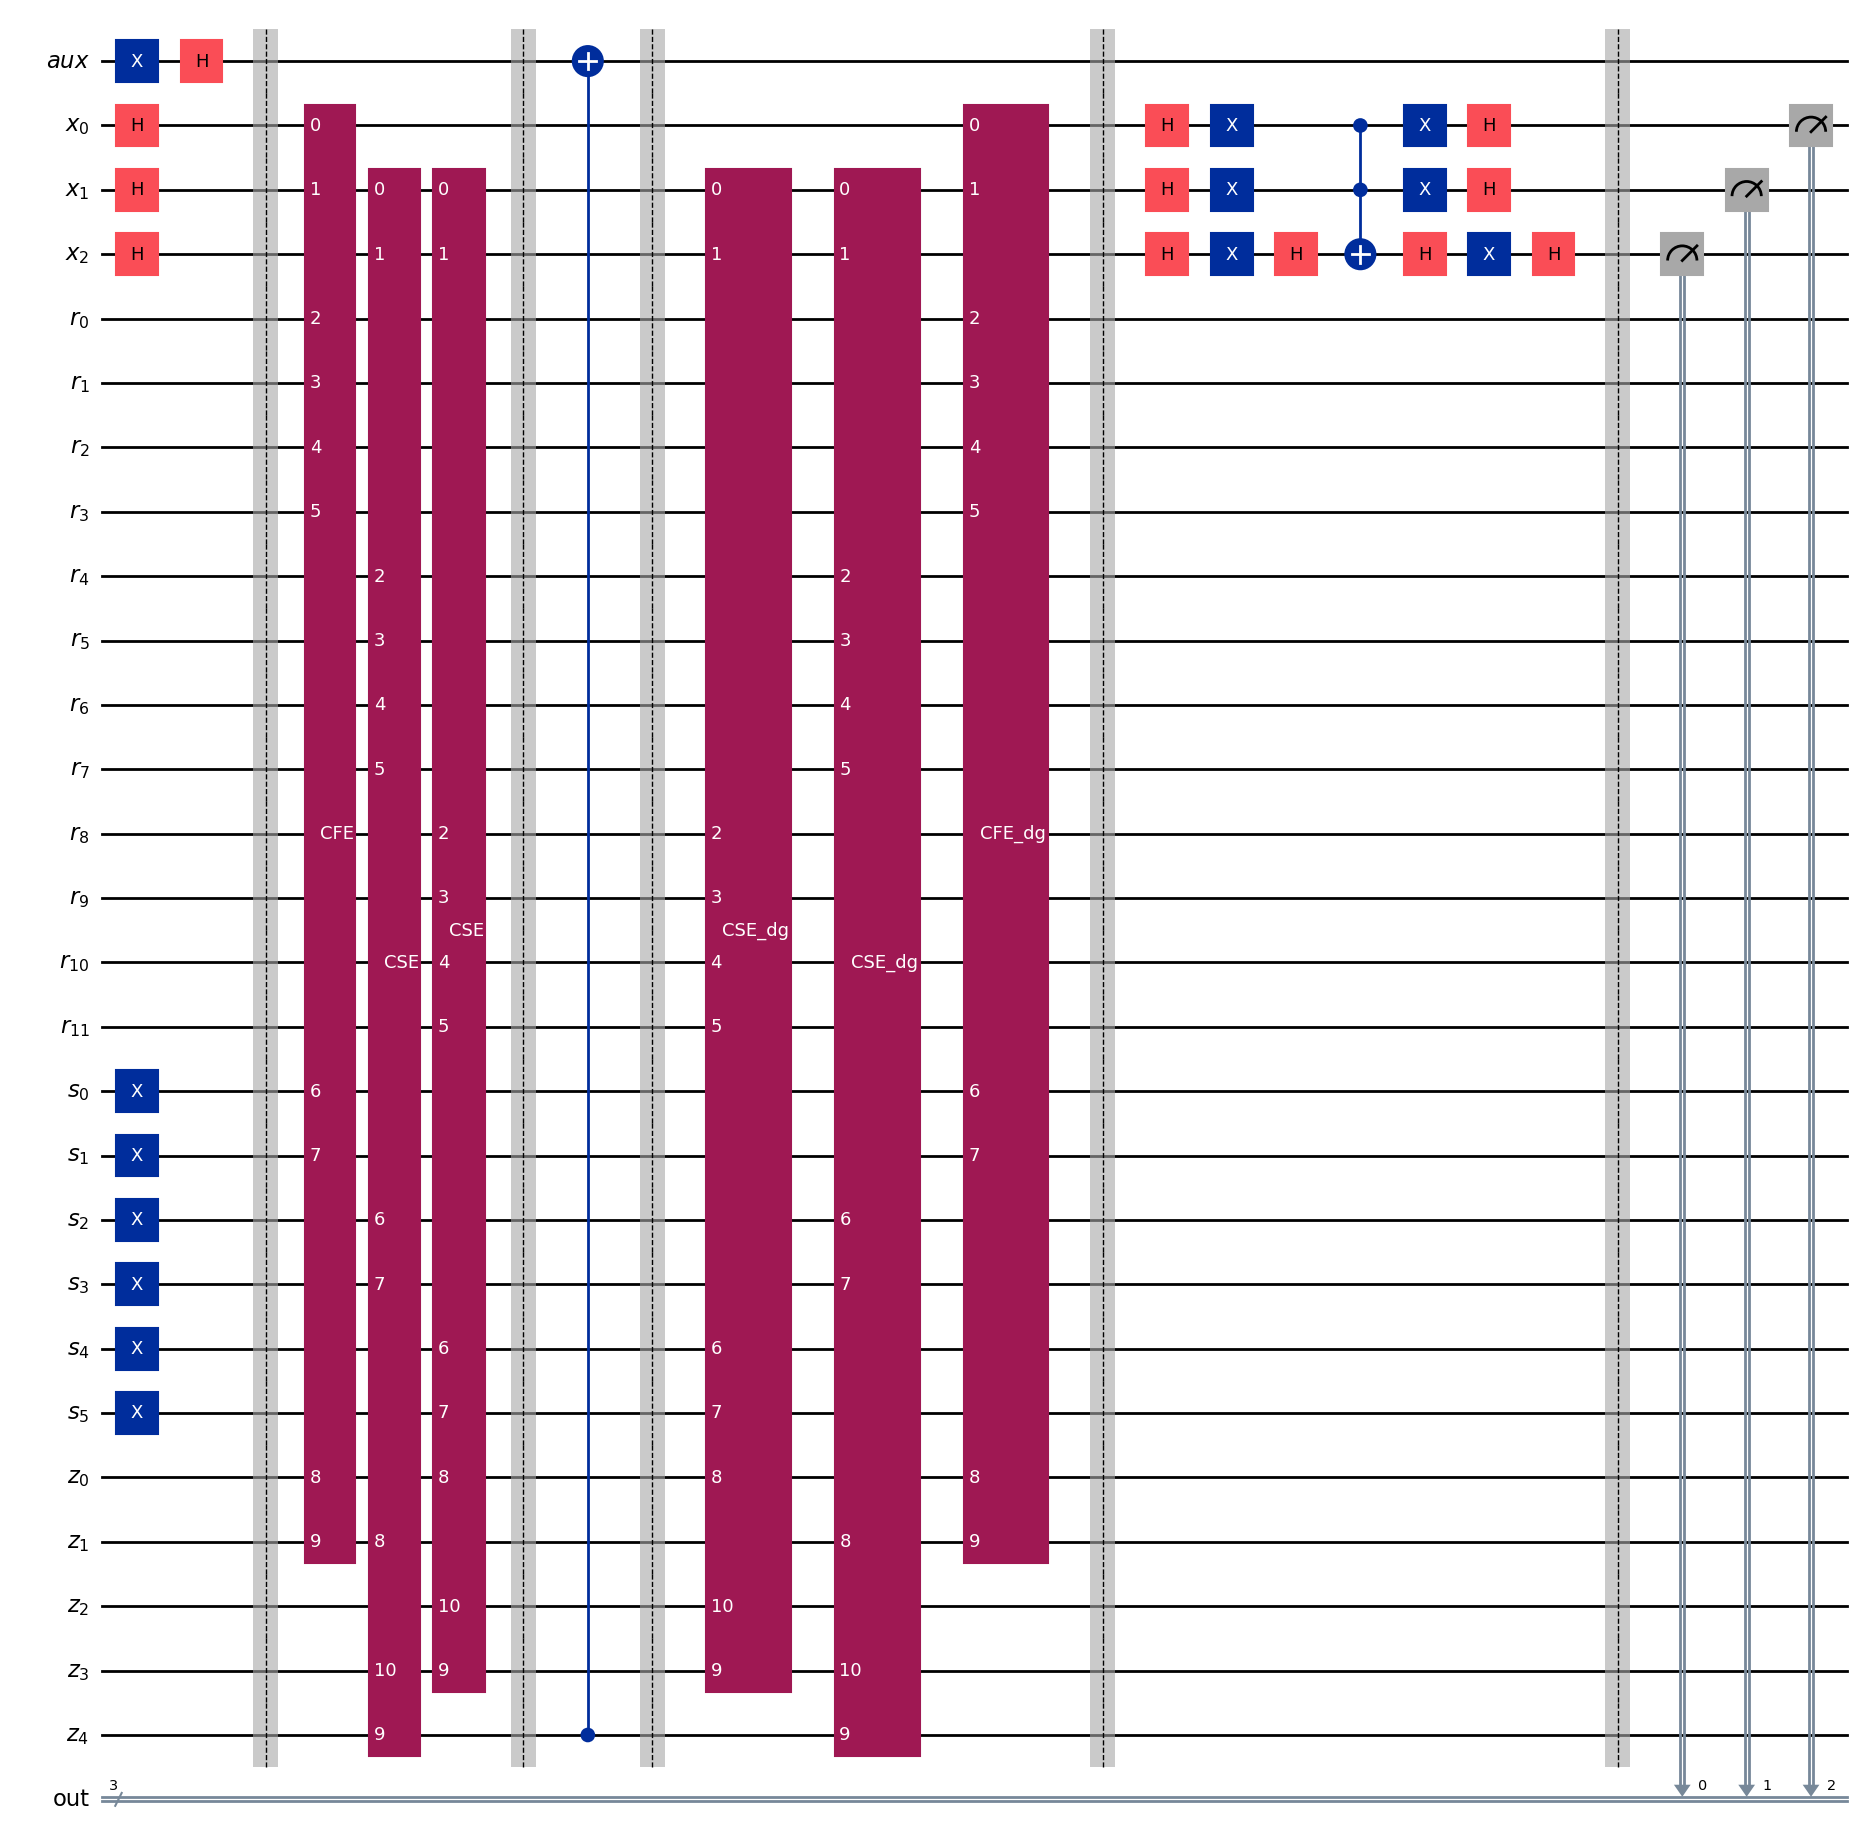

In [260]:
'''
Measurement 
'''

cuts = []
for i in range(len(x_reg)):
    cuts.append(x_reg[i])

# Reverse the order in which the output is shown so that it can be read from left to right.
cuts.reverse()

qc.measure(cuts, readout)

circuit_drawer(qc, output="mpl", fold=-1)

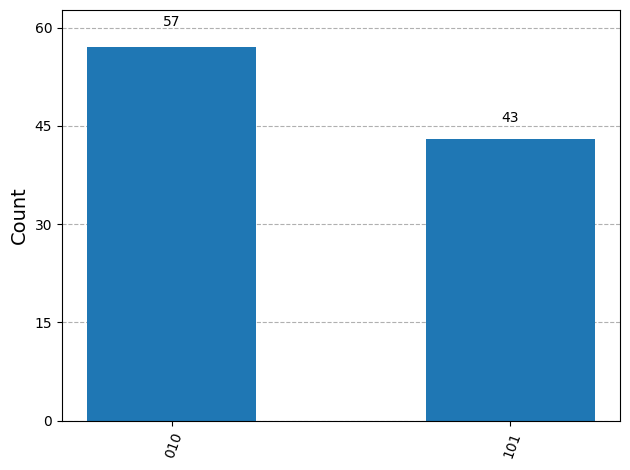

In [261]:
sim = AerSimulator()

qc = transpile(qc, sim)

result = sim.run(qc, shots=100).result()
counts = result.get_counts()

plot_histogram(counts)

## Referências

- [Quantum Speedup for the Maximum Cut Problem](https://arxiv.org/pdf/2305.16644)
- https://github.com/renatawong/quantum-maxcut/blob/5cfe3544b78f365fa78f4d8edba0d7885cbd39e5/quantum_maxcut_algorithm.ipynb
